In [26]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os



## Check which antennas are up
Currently done using code in the snapshot inspection notebook.

In [27]:
'''#The array below is generated with Larry's functions for monitoring the power level. See email 4-18-2023 for details.

#note that this may have been taken with daytime settings by mistake
powerlevels=np.load('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/snap2_control/powerlevels-2023April18-8-19pm-KP.npy')
for b in range(11):
    plt.plot(powerlevels[b,:],label=str(b))
plt.ylim(0,2e-5)
plt.legend()

#good_antennas=np.zeros(powerlevels.shape)
minimum_ok_power=3e-6
maximum_ok_power=7.5e-6
good_antennas=(powerlevels>minimum_ok_power)&(powerlevels<maximum_ok_power)
for b in range(11):
    print(np.sum(good_antennas[b,:]))
    
    
# which are veto

#what are the good veto antennas -- this will be used as the veto antenna roles array
all_veto_antennas=['LWA-331','LWA-348','LWA-364','LWA-322','LWA-347','LWA-326','LWA-333','LWA-328','LWA-316','LWA-325','LWA-334','LWA-297','LWA-342','LWA-350','LWA-356','LWA-261','LWA-315','LWA-264','LWA-300','LWA-329','LWA-290','LWA-287','LWA-357','LWA-286','LWA-275','LWA-302','LWA-363','LWA-349','LWA-355','LWA-279','LWA-319','LWA-299','LWA-289'] #TODO double check that this list is up to date-- does it include the last swaps?
for name in all_veto_antennas:
    input_id=mapping.ant_to_snap2loc(name)  ##
    print(input_id)
    #print(good_antennas[input_id[1],input_id])
#what are the good core antennas -- this will be used as the veto antenna roles array

#which boards have more than 4 veto signals? '''

"#The array below is generated with Larry's functions for monitoring the power level. See email 4-18-2023 for details.\n\n#note that this may have been taken with daytime settings by mistake\npowerlevels=np.load('/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/snap2_control/powerlevels-2023April18-8-19pm-KP.npy')\nfor b in range(11):\n    plt.plot(powerlevels[b,:],label=str(b))\nplt.ylim(0,2e-5)\nplt.legend()\n\n#good_antennas=np.zeros(powerlevels.shape)\nminimum_ok_power=3e-6\nmaximum_ok_power=7.5e-6\ngood_antennas=(powerlevels>minimum_ok_power)&(powerlevels<maximum_ok_power)\nfor b in range(11):\n    print(np.sum(good_antennas[b,:]))\n    \n    \n# which are veto\n\n#what are the good veto antennas -- this will be used as the veto antenna roles array\nall_veto_antennas=['LWA-331','LWA-348','LWA-364','LWA-322','LWA-347','LWA-326','LWA-333','LWA-328','LWA-316','LWA-325','LWA-334','LWA-297','LWA-342','LWA-350','LWA-356','LWA-261','LWA-315','LWA-264','LWA-300','LWA-329','LWA-290','LWA-287

## Connect to SNAP2 boards

In [28]:
brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']
casperbrds = [casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport) for brdname in brdnames]
fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c.fpg'


## Set up ethernet and send a test snapshot

In [51]:
computer='gpu09' # 'lwacr' or 'gpu09'
packetwait=100 #clock cycles between packets
wait_after_readout=200 #time [clock cycles] to wait for other boards to finish readout
for i,brdname in enumerate(brdnames):
    casperbrd=casperbrds[i]
    #prepare to send a snapshot
    
    setup_data_source(casperbrd,"adc") #set the data source to ADC
    setup_ethernet(brdname,casperbrd,fpgfile,computer,packetwait) #set up the ethernet packetizer and ethernet block
    setvalue(casperbrd,'wait_after_readout','cr_registers.xlsx',wait_after_readout) #set the wait time after readout before new internally-generated triggers are accepted
    setvalue(casperbrd,'brd_id','cr_registers.xlsx',int(brdname[-2:])) #set the board id
    setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)  #enable ethernet

Data source set to adc
------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap02:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:02:02:02
Gateway:  0.0.0.1
IP:  10.41.0.202
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap03:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:03:03:03
Gateway:  0.0.0.1
IP:  10.41.0.203
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips:

In [52]:
#[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]

#send trigger to just one board and all will send packets
software_trigger(casperbrds[3],1)

Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 137669 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


In [33]:

[setvalue(casperbrd,'eth_enable','cr_registers.xlsx',0)  for casperbrd in casperbrds]

[None, None, None, None, None, None, None, None, None, None, None]

## Run Trigger 

In [ ]:
#maybe later I will include the packetizer setup here, but I don't want to redo that setup when some boards are already getting eof and valid signals
'''#setup packetizer and enable ethernet
packetwait=200 #clock cycles between packets
wait_after_readout=200 #time [clock cycles] to wait for other boards to finish readout
for i,brdname in enumerate(brdnames):
    casperbrd=casperbrds[i]
    
    setup_data_source(casperbrd,"adc") #set the data source to ADC
    setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',packetwait) #set up the ethernet packetizer and ethernet block
    setvalue(casperbrd,'wait_after_readout','cr_registers.xlsx',wait_after_readout) #set the wait time after readout before new internally-generated triggers are accepted
    setvalue(casperbrd,'brd_id','cr_registers.xlsx',int(brdname[-2:])) #set the board id
    setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)  #enable ethernet
''''''


In [53]:
%%capture output

[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]


current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2023-6-20.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2023-6-20.npy')
ok_snaps=[3,4,5,6,7,8,9] #zero indexed
fname_prefix='/home/ubuntu/kp/data/2023June20/overnight-'

#set up coincidencer
trigger_power_thresh=250**2
veto_power_thresh=250**2
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
antenna_number_thresh=6 
veto_number_thresh=1

bufferwait=2000

for b in ok_snaps:
    casperbrd=casperbrds[b]
    veto_roles_array=current_ok_vetos[b,:]
    core_roles_array=current_ok_core[b,:]

    
    setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)
    setvalue(casperbrd,"delay_trigger","cr_registers.xlsx",bufferwait)

    setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)






now=time.time()
duration=8*60*60 #run for 8 hours
finish=now+duration
waittime=30

snapshots_per_second=np.zeros((11,int(duration/waittime)))
core_triggers=np.zeros((11,int(duration/waittime)))
veto_triggers=np.zeros((11,int(duration/waittime)))
i=0
while time.time()<finish:
    for b in ok_snaps:
        casperbrd=casperbrds[b]
        old_packets=getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx")
        time.sleep(2.75)  #wait to update
        current_packets=getvalue(casperbrd,"eof_and_valid","cr_registers.xlsx")
        veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        new_packets=current_packets-old_packets
        latest_snapshots_per_second=new_packets/(64*2.75)
        snapshots_per_second[b,i]=latest_snapshots_per_second
        core_triggers[b,i]=core_coincidence            
        veto_triggers[b,i]=veto_coincidence
        time.sleep(waittime)
    i+=1

[setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0) for casperbrd in casperbrds]


In [54]:
output.show()

[None, None, None, None, None, None, None, None, None, None, None]

In [55]:
np.save(fname_prefix+'snapshots_from_packetizer',np.asarray(snapshots_per_second))
np.save(fname_prefix+'core',np.asarray(core_triggers))
np.save(fname_prefix+'veto',np.asarray(veto_triggers))

In [56]:
print(i)

126


In [57]:
int(duration/waittime)

960

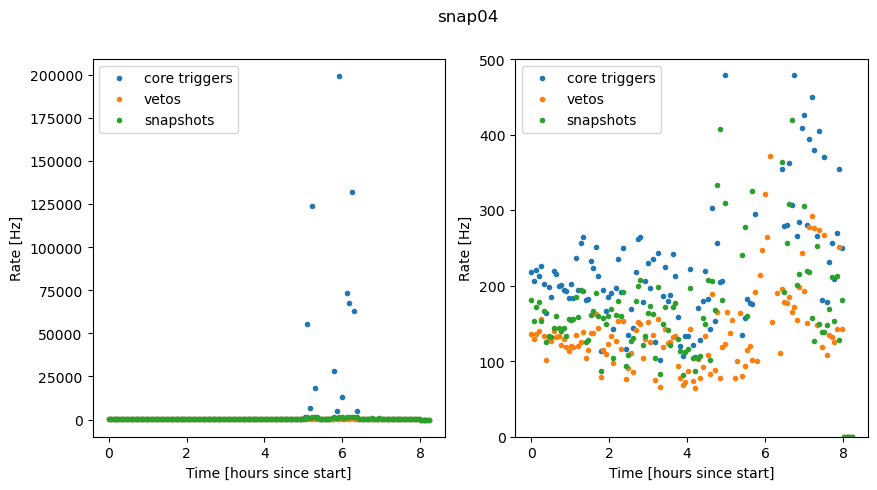

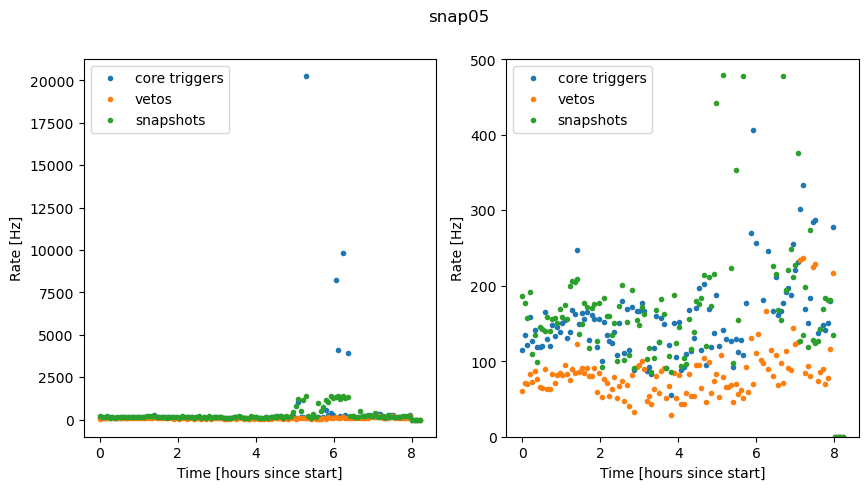

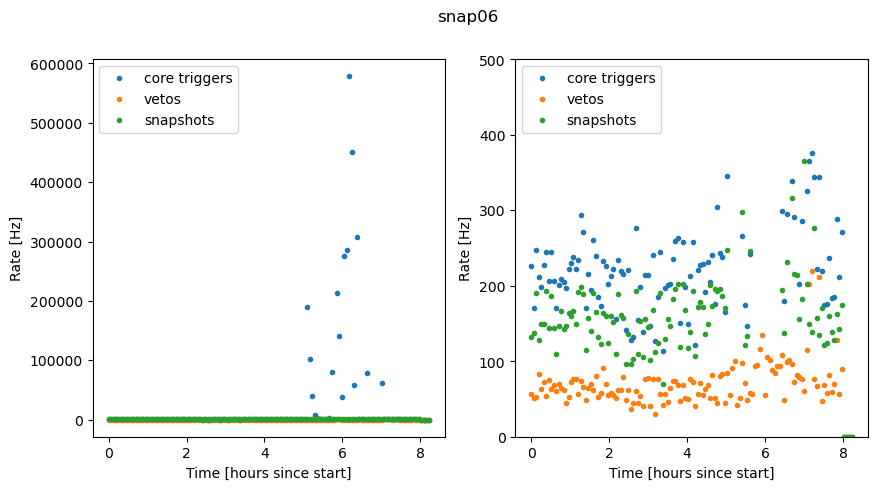

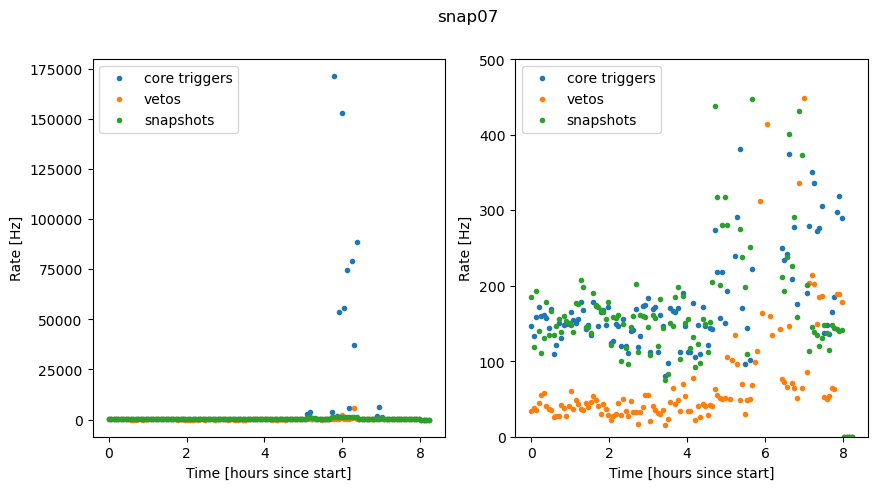

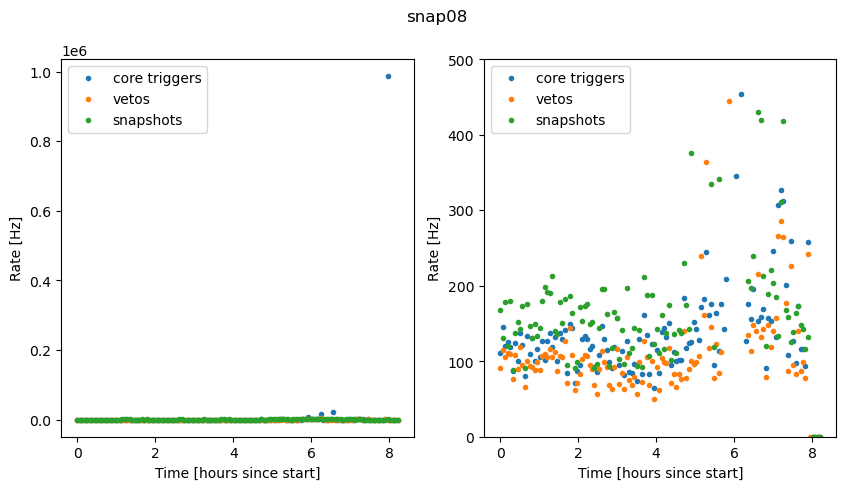

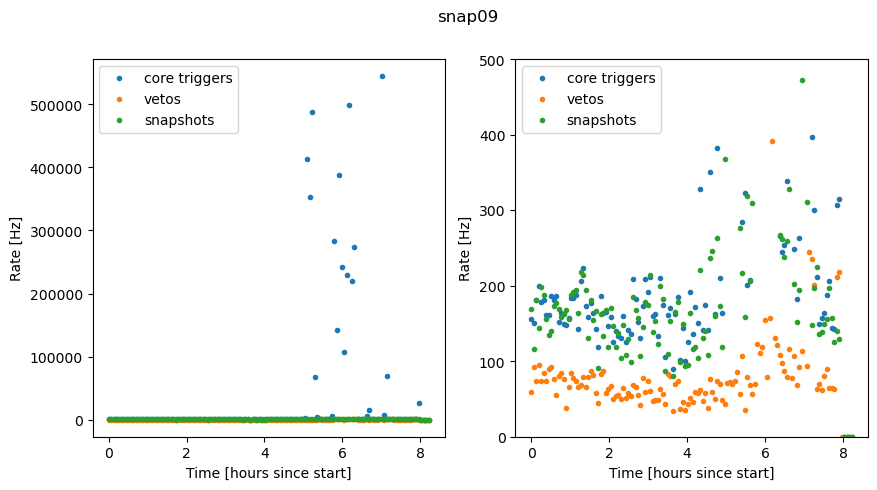

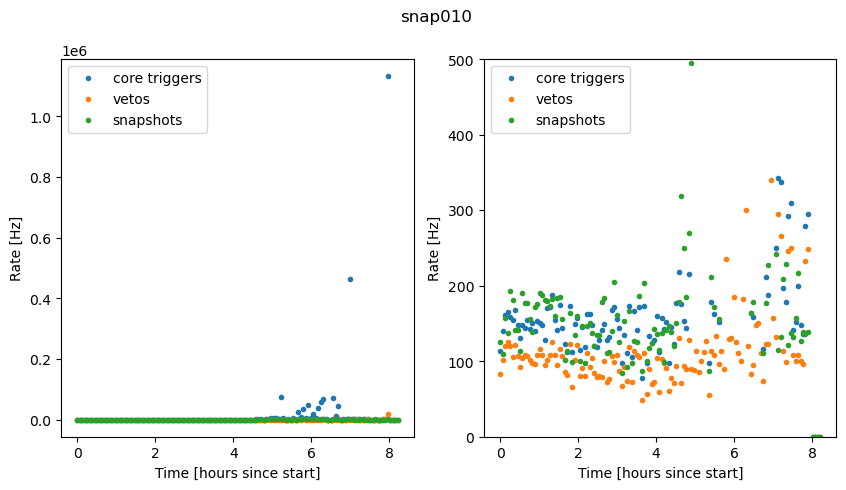

In [62]:


core_all=(np.load(fname_prefix+'core'+'.npy'))*0.73 #convert to Hz
veto_all=(np.load(fname_prefix+'veto'+'.npy'))*0.73 #convert to Hz
snapshots_all=np.load(fname_prefix+'snapshots_from_packetizer'+'.npy')
stoppindex=130 #I made the array too large and it only made this many measurements per board before reaching the stop time
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    snapshots=snapshots_all[b]
    timeaxis=np.asarray(range(len(core)))*(7*32.75)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.figure(figsize=(10,5),dpi=100)
    plt.suptitle('snap0'+str(b+1))
    plt.subplot(121)
    plt.plot(timeaxis[:stoppindex],core[:stoppindex],'.',label='core triggers')
    plt.plot(timeaxis[:stoppindex],veto[:stoppindex],'.',label='vetos')
    plt.plot(timeaxis[:stoppindex],snapshots[:stoppindex],'.',label='snapshots')
    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.subplot(122)
    plt.plot(timeaxis[:stoppindex],core[:stoppindex],'.',label='core triggers')
    plt.plot(timeaxis[:stoppindex],veto[:stoppindex],'.',label='vetos')
    plt.plot(timeaxis[:stoppindex],snapshots[:stoppindex],'.',label='snapshots')
    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.ylim((0,500))
    
